**Tasks Accomplished**

1) Integrating my program with Kartikaya's more smoothly

    a) Figuring out the use of the synthetic control models
    b) Adapting the code to the various changes in variable names, format of data, etc.

2) Predictor variables have been used to find the similar counties (this has yielded better results than just lagged-outcome variables).

    a) The predictor variables used are population, median age, and population density. 
    Population and median age are drawn from the Census Bureau. 
    To get population density, I webscraped a wikipedia article and extracted 
    the land areas of the counties. I then divided the poplation column by the land area column.

    b) This was done because the lagged-outcome-variable model yielded incorrect results. 
    The prediction not match the pre-intervention period and the post-intervention period 
    kept showing that masks were driving up cases.
         i) This was because the donor pool counties had a much lower population (and presumably 
         population density), even though the initial number of cases matched my selected county.

    c) With a combination of lagged-outcome variables and predictor variables,
    the model is working well.

**Remaining Tasks**

1) Do multiple counties simultaneously.

2) Look at the counties of states within the same region instead of limiting ourselves to the counties of any given state

**Long-term**
1) TEX, LATEX, and Overleaf

## Importing Libraries 

In [1]:
#@title DO NOT RUN THIS CELL UNLESS YOU HAVE BEEN DISCONNECTED FROM A SESSION
from google.colab import drive
drive.mount('/content/gdrive') 
#Mounts our drive onto our google colab system

Mounted at /content/gdrive


In [2]:
import sys
!pip uninstall tslib
#There are two modules called tslib. The one that !pip install accesses is NOT the one we want
#This code will uninstall the irrelevant tslib library so that we can then access the relevant one

#sys.path.append('/content/gdrive/Shared drives/dev-SyntheticControl/COVID19-synthetic-control-analysis')

#Attempted Fix #1:
sys.path.append('/content/gdrive/Shared drives/dev-SyntheticControl/COVID19-synthetic-control-analysis')

print(sys.path)
#Adds the synthetic control library from the google drive to the google colab system

['', '/env/python', '/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '/usr/local/lib/python3.6/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.6/dist-packages/IPython/extensions', '/root/.ipython', '/content/gdrive/Shared drives/dev-SyntheticControl/COVID19-synthetic-control-analysis']


In [3]:
#Synthetic control
import tslib

import tslib.src
from tslib.src import tsUtils
from tslib.src.synthcontrol.syntheticControl import RobustSyntheticControl

#Matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import matplotlib as mpl

#Webscraping
import requests
from bs4 import BeautifulSoup

#Miscellaneous
import seaborn as sns
import copy
import pandas as pd
import numpy as np
from datetime import datetime as dtm
from datetime import timedelta as td

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Input Variables 

In [4]:
URL1 ='https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv'
URL2 = "https://raw.githubusercontent.com/nytimes/covid-19-data/master/mask-use/mask-use-by-county.csv"
URL3 = "https://www.census.gov/geographies/reference-files/2017/demo/popest/2017-fips.html"
URL4 = "https://raw.githubusercontent.com/jasonong/List-of-US-States/master/states.csv"

## Finding Similar Counties 

In [5]:
def get_raw_data(URL1, ST_NAME):
  state = pd.read_csv(URL1, index_col=0)
  looking_for_alternative = "cases"
  state=state[state['state']==target].pivot_table(index='county', columns='date', values= looking_for_alternative).fillna(0)
  state_data_of_interest = (pd.read_csv(URL1).
                            set_index(["date", "county", "state"]).
                            drop("fips", axis = 1).
                            xs(ST_NAME, level = "state").
                            reset_index().
                            sort_values(by = ["date", "county"]).
                            set_index(["date", "county"]))

  dates = []
  column_names = []
  for i in days_prior:
    dates.append(dtm.strftime(dtm.strptime(intervention, format) - td(days = i), format))
    if i == 1:
      column_names.append("Scaled magnitude of "+looking_for_alternative+" ("+str(i)+" day prior)")
    else:
      column_names.append("Scaled magnitude of "+looking_for_alternative+" ("+str(i)+" days prior)")
  raw_X = (state[dates].
      rename(columns = dict(zip(state[dates].columns, 
                                column_names))).
      replace({0:np.nan}).
      dropna())
  return raw_X, raw_X.applymap(np.log)

In [6]:
def get_age_database_links(URL4):

  URL4 = "https://www.census.gov/data/tables/time-series/demo/popest/2010s-counties-detail.html" #link for webscraping
  a = BeautifulSoup(requests.get(URL4).text, "html.parser")

  age_html = [i for i in [i for i in  [i for i in [i for i in a.find_all("div") if len(i.get_attribute_list("class"))>0 ]]  if not( i.get_attribute_list("class")[0] in [None, ""])] if i.get_attribute_list("class")[0].startswith("state")][0]
  age_databases = pd.DataFrame( data = [[i.get_text().strip(), i.get_attribute_list("href")[0] ] for i in age_html.find_all("a")], columns = ["State", "Link"]).set_index("State")
  #webscrapes the URL and gets the links to the csv files that contain the census information for each state

  return age_databases

In [7]:
def add_population_to_X(X, age_databases, target):

  main_df = pd.DataFrame()
  for state in age_databases.index: #iterates through the states
    if state == target:
      try:
        x = pd.read_csv("https:" + age_databases["Link"].loc[state]).drop(["SUMLEV", "STNAME", "COUNTY"], axis = 1)
        #reads the csv file for each state

        x = x.groupby("CTYNAME").apply(np.mean).drop(["YEAR"], axis = 1).reset_index()
        #the csv file has information for six years about each county
        #this averages together the census data across those six years for each county
        #the dataframe is grouped by county and the mean function is applied to it

        x["STATE"] = state

        land_area = pd.read_html("https://en.wikipedia.org/wiki/List_of_counties_in_"+state.replace(" ", "_"))
        #for webscraping the area of each county in the state (allowing me to calculate the population density of each county)
        land_area = [i for i in land_area if len(i.columns) > 8][0]
        #goes to the correct table on the wikipedia page

        division = land_area.columns[0] #this is the county/parish
        land_area = land_area.drop(["Map"], axis = 1, errors = "ignore").set_index(division)
        #Most wikipedia pages have a column that shows a map of where the county is; I'm dropping it
        #I am ignoring errors, because those will probably come from pages that don't have that column, in which case nothing needs to be done
        #the county is set as the index

        land_area = land_area[ [ land_area.columns[-1]] ].applymap(lambda area: float("".join((area.split()[0]).split(",")))  ).rename(columns = {land_area.columns[-1]:"Land Area"}).applymap(round).reset_index()
        #fixes the formatting of the numbers in the area column (they are strings with commas ever three digits)
        
        x = x.merge(land_area, left_on = "CTYNAME", right_on = division).drop([division], axis = 1)
        #merges the census dataframe and the wikipedia dataframe into a single dataframe about the state

        x["Population Density"] = x["POPESTIMATE"] / x["Land Area"]
        main_df = pd.concat([main_df, x])
        #adds in the dataframe about the state to the overall dataframe about the country
        print(state)
      except:
        print(state + " (Could not add)") #If anything went wrong, I'm not sure how to fix it, so I'll just ignore that state
  main_df = (main_df.rename(columns = {"CTYNAME":"County", "STATE":"State"}).
            set_index(["State", "County"])
            [["POPESTIMATE", "MEDIAN_AGE_TOT", "Population Density"]].
            rename(columns = dict(zip ( ["POPESTIMATE", "MEDIAN_AGE_TOT"],
                                        ["Population", "Median Age"]) ),
                    errors = "ignore" ).
            xs(target))

  main_df.index = [i.split(" County")[0] for i in main_df.index]
  X = X.join(main_df)
  return X

In [8]:
def further_scaling(X):
  X["Population"] = X["Population"].apply(np.log)
  X["Population Density"] = X["Population Density"].apply(np.log)

  for i in X.columns:
    X[i] = 100*(X[i] - min(X[i]) ) / (max(X[i]) - min(X[i])) #min-max scaling

  X.columns = list(X.columns[:-3])+[i+" (Scaled)" for i in X.columns[-3:] ]
  return X

In [9]:
#Gets the New York Times data

def NYTimesMaskData(URL2, ST_NAME):

  nyTimesMaskPolicy = pd.read_csv(URL2, dtype=str).set_index("COUNTYFP")
  #************************************************************************************************************************
  a = dtm.now()
  soup = BeautifulSoup(requests.get(URL3).text, "html.parser")
  spreadsheets = [i for i in soup.find_all("a") if i.get_attribute_list("class")[0] == "uscb-text-link"]
  countyFIPS_link = [i for i in spreadsheets if "County" in i.get_text()][0].get_attribute_list("href")[0]
  countyFIPS = pd.read_excel("https:"+countyFIPS_link, skiprows = 4, dtype=str)
  countyFIPS["County Code"] = countyFIPS["State Code (FIPS)"] + countyFIPS["County Code (FIPS)"]
  countyFIPS = countyFIPS.rename(columns = {"Area Name (including legal/statistical area description)":"Place"})[["Place", "County Code", "State Code (FIPS)", "County Code (FIPS)"]]

  states = list(pd.read_csv("https://raw.githubusercontent.com/jasonong/List-of-US-States/master/states.csv")["State"])
  stateFIPS = countyFIPS[countyFIPS["Place"].isin(states)].set_index("Place").applymap(lambda x: x[:2])
  countyFIPS = countyFIPS[countyFIPS["Place"].str.lower().apply(lambda x: x.endswith("county"))]
  countyFIPS["State"] = ""

  for i in countyFIPS.index:
    number = countyFIPS.loc[i, "State Code (FIPS)"]
    countyFIPS.loc[i, "State"] = stateFIPS.reset_index().set_index("County Code").loc[number]["Place"]

  state_county_FIPS = (countyFIPS.query("State == '"+ST_NAME+"'").
                      reset_index(drop = True).
                      applymap(lambda x: x.split(" County")[0]))

  b = dtm.now()
  print("Time to run function:", b-a)
  state_county_FIPS
  #************************************************************************************************************************

  weighted_sum = 0
  for i in range(5):
    weighted_sum += i*nyTimesMaskPolicy[nyTimesMaskPolicy.columns[i]].apply(float)


  relevant_FIPS_codes = list((state_county_FIPS["State Code (FIPS)"] + state_county_FIPS["County Code (FIPS)"]).values)
  state_counties_mask_usage = (weighted_sum.loc[relevant_FIPS_codes]
                              .reset_index().set_index("COUNTYFP")
                              .join(state_county_FIPS.set_index("County Code"))[["NEVER", "Place"]]
                              .rename(columns = {"NEVER":"Usage Index", "PLACE":"County"}))
  
  return state_counties_mask_usage.sort_values(by = "Usage Index").iloc[[0, -1]], state_counties_mask_usage

In [10]:
def find_closest_counties(df, county):
  new_df = pd.DataFrame(columns = ["Euclidean Distance from "+county])
  for value in (df.index):
    new_df.loc[value] = (((df.loc[county] - df.loc[value])**2).sum())**0.5
  return new_df

In [11]:
divisions = 3
middle_counterfactual = 2

def extract_donor_pool(closeness_scores2, state_counties_mask_usage, counties_in_donor_pool,
                       divisions = 2, middle_counterfactual = 2):
  initial_county_number = round(len(closeness_scores2)/2)
  closeness_scores = (closeness_scores2.
                      join(state_counties_mask_usage.reset_index().
                          set_index("Place")).
                      dropna())


  mean_score = 3.1 #np.mean(closeness_scores["Usage Index"])
  standard_deviation = np.std(closeness_scores["Usage Index"])

  if divisions == 3:
    closeness_scores["Group"] = closeness_scores["Usage Index"] - mean_score
    for i in closeness_scores.index:
      if abs(closeness_scores.loc[i]["Group"])<=standard_deviation:
        closeness_scores.loc[i, "Group"] = 1
      else:
        closeness_scores.loc[i, "Group"] = 2*int(closeness_scores.loc[i]["Usage Index"] > mean_score)
  else:
    closeness_scores["Group"] = 2*((closeness_scores["Usage Index"] >= mean_score).apply(int)) 
  closeness_scores

  county_of_interest_group = closeness_scores.loc[county_of_interest]["Group"]
  counterfactual_group = 2*(county_of_interest_group < 1)
  if county_of_interest_group == 1:
    counterfactual_group = middle_counterfactual

  donor_pool_table = (closeness_scores.
                      query("Group == "+str(counterfactual_group)).
                      sort_values(by = closeness_scores.columns[0]).
                      head(counties_in_donor_pool))
  donor_pool = list(donor_pool_table.index)
  return donor_pool, closeness_scores, mean_score, standard_deviation

In [162]:
format = "%Y-%m-%d"
county = "Collin" #to change
target = "Texas" #to change

specific_intervention_dates = {"Kansas":"2020-06-02",
                               "Texas":"2020-07-02",
                               "South Carolina":"2020-07-29",
                               "Pennsylvania":"2020-07-01"}

date   = "2020-06-01" #to change
#date = specific_intervention_dates[target]
start  = "2020-03-10" #to change
end    = "2020-09-15" #to change
max_euclidean_distance = 50
counties_in_donor_pool = 6
download_output = False


ST_NAME = target
intervention = date
county_of_interest = str(county)
days_prior = [1, 7, 15] #How many days before the intervention date do we want to consider?
raw_X, X = get_raw_data(URL1, ST_NAME)
age_databases = get_age_database_links(URL4)
X = add_population_to_X(X, age_databases, target)
X = further_scaling(X)
extremes, state_counties_mask_usage = NYTimesMaskData(URL2, ST_NAME)

closeness_scores2 = (find_closest_counties(X, county_of_interest).
                    sort_values("Euclidean Distance from "+county_of_interest).
                    query("`Euclidean Distance from "+county_of_interest+"` <= "+str(max_euclidean_distance)))

donor_pool, closeness_scores, mean_score, standard_deviation = extract_donor_pool(closeness_scores2, state_counties_mask_usage, counties_in_donor_pool,
                                                                                  divisions = 2, middle_counterfactual = 0)

print("Donor pool: ", donor_pool)
closeness_scores#[closeness_scores["Group"]==0]

Texas
Time to run function: 0:00:10.478405
Donor pool:  ['Randall', 'Potter', 'Smith']


,Euclidean Distance from Collin,COUNTYFP,Usage Index,Group
Collin,0.000000,48085,3.553,2
Denton,6.342480,48121,3.565,2
Fort Bend,8.686603,48157,3.585,2
Montgomery,12.559137,48339,3.390,2
Galveston,15.795280,48167,3.336,2
Williamson,19.130826,48491,3.526,2
El Paso,19.155847,48141,3.806,2
Bexar,19.309539,48029,3.688,2
Travis,19.460573,48453,3.710,2
Brazoria,22.404562,48039,3.466,2


In [163]:
state = pd.read_csv(URL1, index_col=0)
looking_for_alternative = "cases"
state=state[state['state']==target].pivot_table(index='county', columns='date', values= looking_for_alternative).fillna(0)
data = state[[i for i in state.columns if 
              (dtm.strptime(i, format)<=dtm.strptime(end, format)) and 
              (dtm.strptime(i, format)>=dtm.strptime(start, format))]].reindex(donor_pool+[county_of_interest])

group_of_county = closeness_scores.loc[county_of_interest]["Group"]
usage_of_county = closeness_scores.loc[county_of_interest]["Usage Index"]
data[["2020-05-30", "2020-05-31", "2020-06-01", "2020-06-02"]]

date,2020-05-30,2020-05-31,2020-06-01,2020-06-02
county,,,,
Randall,674.0,674.0,688.0,711.0
Potter,2321.0,2321.0,2354.0,2432.0
Smith,204.0,204.0,210.0,212.0
Collin,1297.0,1312.0,1315.0,1315.0


## Performing Synthetic Control

In [164]:
allColumns = data.columns.values
years = list(data.columns)
caStateKey = county
otherStates = [i for i in data.index if i!=county_of_interest]
p = 1.0
yearTrainEnd = intervention
#*******************************************************************************
testYears=list(years)[list(years).index(date):len(list(years))]
trainingYears=list(years)[list(years).index(start):list(years).index(date)]
trainDF = data[trainingYears].T.reset_index(drop = True)
testDF = data[testYears].T.reset_index(drop = True)
trainDF = data[trainingYears].T.reset_index(drop = True)
testDF = data[testYears].T.reset_index(drop = True)



singvals = min(4, len(donor_pool))#counties_in_donor_pool
print(singvals)
print(len(donor_pool))
rscModel = RobustSyntheticControl(caStateKey, singvals, len(trainDF), probObservation=1.0, modelType='svd', svdMethod='numpy', otherSeriesKeysArray=otherStates)
rscModel.fit(trainDF)
denoisedDF = rscModel.model.denoisedDF()
predictions = []
predictions = np.dot(testDF[otherStates], rscModel.model.weights)
actual = data.loc[caStateKey]
model_fit = np.dot(trainDF[otherStates][:], rscModel.model.weights)


trainDF

3
3


county,Randall,Potter,Smith,Collin
0,0.0,0.0,0.0,3.0
1,0.0,0.0,0.0,3.0
2,0.0,0.0,0.0,4.0
3,0.0,0.0,3.0,5.0
4,0.0,0.0,3.0,7.0
...,...,...,...,...
78,655.0,2266.0,200.0,1217.0
79,658.0,2276.0,202.0,1236.0
80,671.0,2317.0,204.0,1278.0
81,674.0,2321.0,204.0,1297.0


## Plotting graph

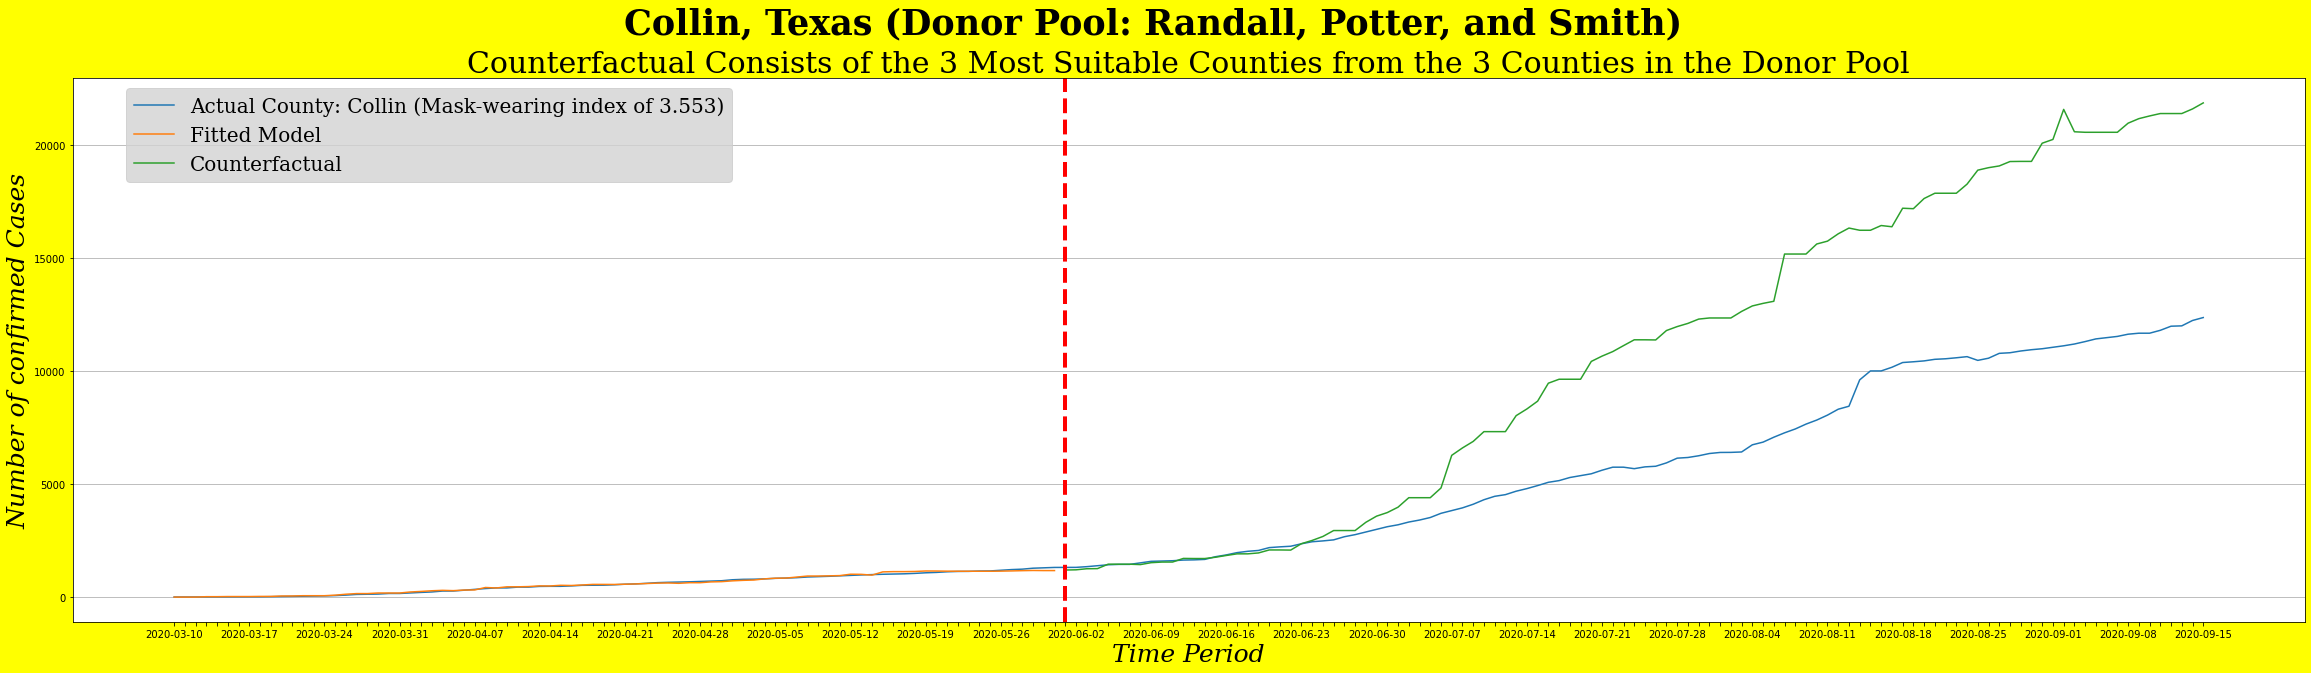

In [165]:
face_state_dict = {"Texas":"yellow",
                   "South Carolina":"sandybrown",
                   "Kansas":"gold",
                   "West Virginia":"papayawhip",
                   "Ohio":"lightblue",
                   "Pennsylvania":"aquamarine"}

try:
  fig = plt.figure(figsize=(40,10), facecolor = face_state_dict[ST_NAME])
except:
  fig = plt.figure(figsize=(40,10))
tick_spacing = 1
intDate=yearTrainEnd
plt.plot(years, actual)

plt.xlabel('Time Period', family = "serif", 
           fontsize = 25, style = "italic")
plt.ylabel('Number of confirmed Cases', family = "serif", 
           fontsize = 25, style = "italic")
plt.plot(trainingYears, model_fit, label='fitted model')
plt.plot(testYears, predictions, label='counterfactual')


plt.title("Counterfactual Consists of the "+str(singvals)+" Most Suitable Counties from the "+str(len(donor_pool))+" Counties in the Donor Pool",
          fontsize = 30,
          fontname = "Serif")

donor_pool = donor_pool[: min(6, len(donor_pool))]

plt.suptitle(county_of_interest+", "+ST_NAME+" (Donor Pool: "+", ".join(donor_pool[:-1])+", and "+donor_pool[-1]+")",
             fontname = "Serif",
             fontsize = 35,
             weight = 800)

plt.legend(['Actual County: '+county_of_interest+" (Mask-wearing index of "+str(usage_of_county)+")",
            "Fitted Model",
            "Counterfactual"],
           prop = {"size":20,
                   "family":"Serif"},
           bbox_to_anchor = (0.3, 1),
           facecolor = "lightgray")
n = 7  # Keeps every 7th label
ax = plt.gca()
[l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % n != 0]

#plt.xticks(rotation=90)
plt.axvline(x=str(intDate), color='r', linestyle='--', linewidth=4)
plt.grid(axis = "y")

if download_output == True:
  file_names = [caStateKey+" ("+str(singvals)+' Best Values from a Donor pool of '+str(len(donor_pool))+' Values Used) '+dtm.strftime(dtm.now(), "%m_%d_%Y_%H%M%S")+".png",
                "Closeness Scores of Nearby Counties to "+caStateKey+" "+dtm.strftime(dtm.now(), "%m_%d_%Y_%H%M%S")+".csv",
                "Input Variables For Determining Closenessto "+caStateKey+" "+dtm.strftime(dtm.now(), "%m_%d_%Y_%H%M%S")+".csv",
                "Data for the Donor Pool (and for "+caStateKey+") "+dtm.strftime(dtm.now(), "%m_%d_%Y_%H%M%S")+".csv"]
  plt.savefig(file_names[0], facecolor = face_state_dict[ST_NAME]) #If so, then save the graph
  closeness_scores.to_csv(file_names[1])
  X.to_csv(file_names[2])
  data.to_csv(file_names[3])
  from google.colab import files
  for i in file_names:
    files.download(i)

plt.show()

In [157]:
change = round(100*(predictions[-1] / data.loc[county_of_interest].iloc[-1])-100, 
      2)

if change < 0:
  word = "fewer"
else:
  word = "more"

if  closeness_scores["Group"].loc[county_of_interest] == 2:
  phrase = "a more lenient"
else:
  phrase = "a stricter"


print(("As of {}, {} County would have had {}% "+
       word+" cases if it had followed "+phrase+" policy toward Covid-19.").
      format(
          dtm.strftime(dtm.strptime(data.columns[-1], format), "%B %d, %Y"),
          county_of_interest,
          abs(change)
          ))

As of September 15, 2020, Atchison County would have had 22.8% fewer cases if it had followed a stricter policy toward Covid-19.


In [148]:
closeness_scores.reindex(donor_pool)["Usage Index"].mean()

3.235